In [51]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

In [2]:
df = pd.read_csv("/home/rakin/ML_Projects/new.csv")
df = df.drop(['Unnamed: 0'],axis=1)

In [3]:
df.columns

Index(['gen_1_dispatched', 'gen_2_dispatched', 'gen_3_dispatched',
       'gen_4_dispatched', 'gen_5_dispatched', 'gen_6_dispatched',
       'gen_7_dispatched', 'gen_8_dispatched', 'gen_9_dispatched',
       'gen_10_dispatched', 'Reserve Size', 'Disturbance Size', 'ROCOF',
       'Settling Frequency', 'Nadir'],
      dtype='object')

In [4]:
Y = df.values[:,-3:]
X = df.values[:,:-3]

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [94]:
# Normalize the target variables using MinMaxScaler
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
target1 = scaler2.fit_transform(Y_train[:,0].reshape(-1,1))
target2 = scaler.fit_transform(Y_train[:,1].reshape(-1,1))
target3 = scaler.fit_transform(Y_train[:,2].reshape(-1,1))

# Concatenate the normalized target variables
Y_train = np.concatenate((target1, target2, target3), axis=1)


In [95]:
from keras.callbacks import *
# filepath='./val_aux_output_accuracy:{val_accuracy:.3f}-epochs:{epoch:03d}.hdf5'
filepath = './Best_model_6.hdf5'
#earlyStopping = EarlyStopping(monitor='val_aux_output_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose = 1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, mode='min',patience=2,verbose=1,min_lr=0.0001)
#callbacks_list = [checkpoint]
callbacks_list = [checkpoint,reduce_lr]

In [96]:
model=tf.keras.Sequential([tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(12,input_dim=12,activation='relu'),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(24,activation='relu'),
                           tf.keras.layers.Dense(16,activation='relu'),
                           tf.keras.layers.Dense(3,activation='linear')
                           ])
model.compile(optimizer='RMSprop',loss='mse',metrics=['mse'])


In [97]:

history=model.fit(X_train,Y_train,epochs=300,batch_size=64,validation_split=0.3,callbacks=callbacks_list)

Epoch 1/300
16/16 [==============================] - ETA: 0s - loss: 0.1203 - mse: 0.1203
Epoch 1: val_mse improved from inf to 371.41080, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 3s 35ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 371.4108 - val_mse: 371.4108 - lr: 0.0010
Epoch 2/300
13/16 [=======================>......] - ETA: 0s - loss: 0.0405 - mse: 0.0405
Epoch 2: val_mse improved from 371.41080 to 167.24934, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 0s 19ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 167.2493 - val_mse: 167.2493 - lr: 0.0010
Epoch 3/300
13/16 [=======================>......] - ETA: 0s - loss: 0.0176 - mse: 0.0176
Epoch 3: val_mse improved from 167.24934 to 60.49200, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 0s 22ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 60.4920 - val_mse: 60.4920 - lr: 0.0010
Epoch 4/300
13/16 [=======================>......] - ET

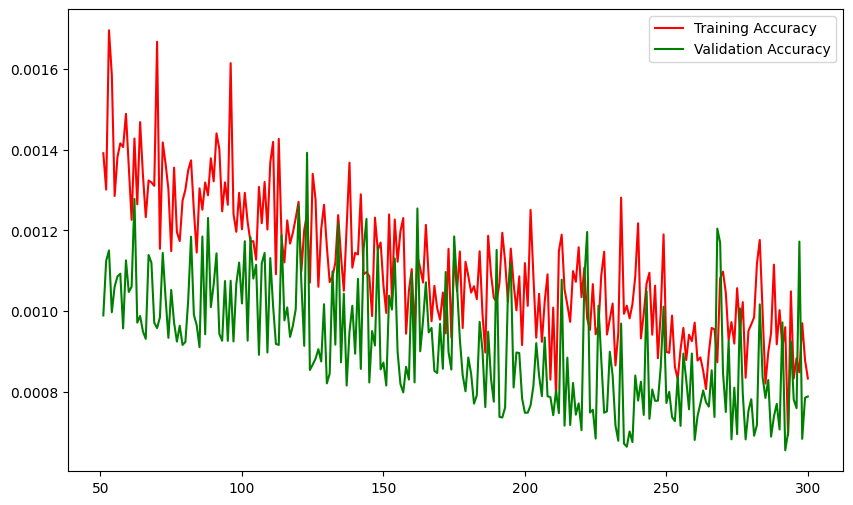

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 12)               48        
 chNormalization)                                                
                                                                 
 dense_112 (Dense)           (None, 12)                156       
                                                                 
 dense_113 (Dense)           (None, 64)                832       
                                                                 
 dense_114 (Dense)           (None, 128)               8320      
                                                                 
 dense_115 (Dense)           (None, 128)               16512     
                                                                 
 dense_116 (Dense)           (None, 512)               66048     
                                                     

In [98]:
plt.figure(figsize=(10,6))
training_accuracy=history.history['loss'][50:]
epochs=range(51,301)
vali_ac=history.history['val_loss'][50:]
plt.plot(epochs,training_accuracy,'r',label='Training Accuracy')
plt.plot(epochs,vali_ac,'g',label='Validation Accuracy')
plt.legend()
plt.show()
model.summary()

In [100]:
def error_calculate(yhat,ytrue):
    error1 = 0
    error2 = 0
    error3 = 0
    for i in range(len(yhat)):
        error1 = error1 + ((ytrue[i,0]-yhat[i,0])**2)
        error2 = error2 +  ((ytrue[i,1]-yhat[i,1])**2)
        error3 = error3 + ((ytrue[i,2]-yhat[i,2])**2)
    print("MSE:",error1/len(yhat)," ",error2/len(yhat)," ",error3/len(yhat))
Model = tf.keras.models.load_model(filepath)
yhat = Model.predict(X_test)
y1=scaler2.inverse_transform(yhat[:,0].reshape(-1,1))
y2=scaler.inverse_transform(yhat[:,1:].reshape(-1,2))
yhat = np.concatenate([y1,y2],axis=1)
ytrue = Y_test
error_calculate(yhat,ytrue)

19/19 [==============================] - 0s 4ms/step
MSE: 0.0001645311549953504   0.0213308551689373   0.015510145805152808


In [101]:
yhat

array([[ 0.06959042, 49.54025   , 49.398193  ],
       [ 0.09740184, 49.477356  , 49.178066  ],
       [ 0.16548097, 49.2407    , 48.23858   ],
       ...,
       [ 0.07951374, 49.56269   , 49.359875  ],
       [ 0.15664282, 49.245796  , 48.31845   ],
       [ 0.14010192, 49.29443   , 48.521786  ]], dtype=float32)

In [102]:
column = ['ROCOF(Predicted)','ROCOF(Actual)','Settling Frequency(Predicted)','Settling Frequency(Actual)','Nadir(Predicted)','Nadir(Actual)']
result_df = pd.DataFrame(columns=column)
result_df['ROCOF(Predicted)']= yhat[:,0]
result_df['Settling Frequency(Predicted)']=yhat[:,1]
result_df['Nadir(Predicted)']=yhat[:,2]
result_df['ROCOF(Actual)']= ytrue[:,0]
result_df['Settling Frequency(Actual)']=ytrue[:,1]
result_df['Nadir(Actual)']=ytrue[:,2]
result_df.to_csv("test_result.csv")